In [1]:
# --- Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from mpl_toolkits.mplot3d import Axes3D

Closed-form (no reg): MSE=239357657.43, RMSE=15471.19, MAE=10005.45, R2=0.4332
Gradient Descent (no reg): MSE=333333858.38, RMSE=18257.43, MAE=11987.07, R2=0.2107
Closed-form (λ=0): MSE=239357657.43, RMSE=15471.19, MAE=10005.45, R2=0.4332
Closed-form (λ=1): MSE=238951584.52, RMSE=15458.06, MAE=9986.70, R2=0.4342
Closed-form (λ=10): MSE=237174595.07, RMSE=15400.47, MAE=9861.57, R2=0.4384
Closed-form (λ=100): MSE=252459040.24, RMSE=15888.96, MAE=10095.50, R2=0.4022
Closed-form (λ=1000): MSE=278487625.55, RMSE=16687.95, MAE=10571.58, R2=0.3406
Closed-form STD (λ=0): MSE=239357657.43, RMSE=15471.19, MAE=10005.45, R2=0.4332
Closed-form STD (λ=1): MSE=239200533.96, RMSE=15466.11, MAE=9998.79, R2=0.4336
Closed-form STD (λ=10): MSE=237857213.76, RMSE=15422.62, MAE=9942.02, R2=0.4368
Closed-form STD (λ=100): MSE=229594215.31, RMSE=15152.37, MAE=9515.14, R2=0.4563
Closed-form STD (λ=1000): MSE=254307026.19, RMSE=15947.01, MAE=9527.68, R2=0.3978


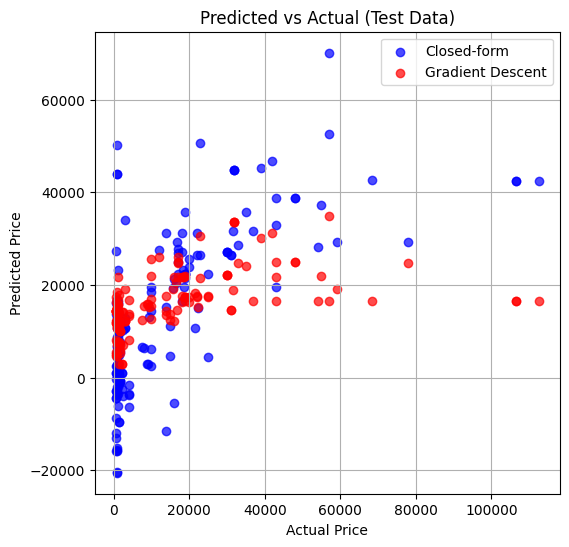

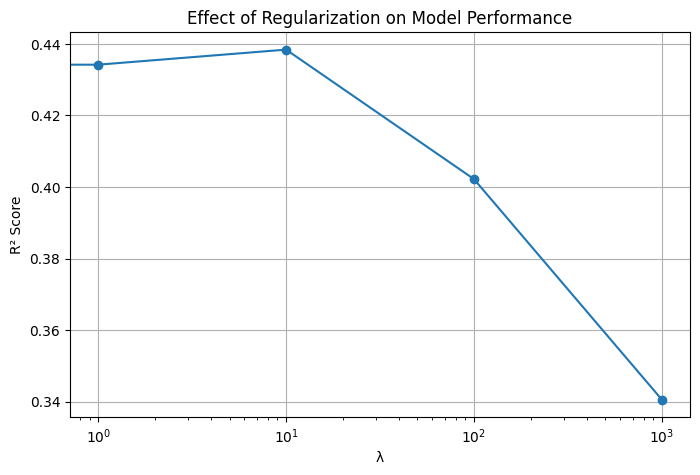


Feature Importance (|weights| standardized, λ=1):
Bias             14287.049612
Ratings           9692.156085
RAM               5700.134255
Primary_Cam       5286.525143
ROM               3941.592734
Battery_Power     2208.697763
Selfi_Cam          828.568473
Mobile_Size        465.636685
dtype: float64


In [7]:
# ------------------------------------------------------------
# 1.1 REGRESSION: Mobile Phone Price Prediction
# ------------------------------------------------------------

# === Load dataset ===
df = pd.read_csv("/content/Mobile-Price-Prediction-cleaned_data.csv")

# Features and Target
X = df[['Ratings','RAM','ROM','Mobile_Size','Primary_Cam','Selfi_Cam','Battery_Power']].values
y = df['Price'].values.reshape(-1, 1)

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add bias (intercept)
def add_bias(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

X_train_b = add_bias(X_train)
X_test_b = add_bias(X_test)

# === Closed-form Linear Regression ===
def closed_form(X, y, lam=0.0):
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0,0] = 0  # Don't regularize intercept
    w = np.linalg.inv(X.T @ X + lam * I) @ X.T @ y
    return w

# === Gradient Descent ===
def gradient_descent(X, y, lam=0.0, lr=0.00000001, epochs=10000):
    m, n = X.shape
    w = np.zeros((n,1))
    for i in range(epochs):
        y_pred = X @ w
        grad = (2/m) * X.T @ (y_pred - y) + 2*lam*w
        grad[0] -= 2*lam*w[0]  # don't regularize intercept
        w -= lr * grad
    return w

# === Evaluation function ===
def evaluate(y_true, y_pred, label="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label}: MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}")
    return mse, rmse, mae, r2

# Closed-form solution
w_closed = closed_form(X_train_b, y_train)
y_pred_closed = X_test_b @ w_closed
evaluate(y_test, y_pred_closed, "Closed-form (no reg)")

# Gradient descent
w_gd = gradient_descent(X_train_b, y_train)
y_pred_gd = X_test_b @ w_gd
evaluate(y_test, y_pred_gd, "Gradient Descent (no reg)")

# === L2 Regularization experiments ===
lambdas = [0, 1, 10, 100, 1000]
results = []

for lam in lambdas:
    w_l2 = closed_form(X_train_b, y_train, lam)
    y_pred = X_test_b @ w_l2
    mse, rmse, mae, r2 = evaluate(y_test, y_pred, f"Closed-form (λ={lam})")
    results.append([lam, mse, rmse, mae, r2])

# === Standardization + L2 ===
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
X_train_std_b = add_bias(X_train_std)
X_test_std_b = add_bias(X_test_std)

results_std = []
for lam in lambdas:
    w_std = closed_form(X_train_std_b, y_train, lam)
    y_pred_std = X_test_std_b @ w_std
    mse, rmse, mae, r2 = evaluate(y_test, y_pred_std, f"Closed-form STD (λ={lam})")
    results_std.append([lam, mse, rmse, mae, r2])

# === Plot Predicted vs Actual ===
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_closed, alpha=0.7, color='blue', label='Closed-form')
plt.scatter(y_test, y_pred_gd, alpha=0.7, color='red', label='Gradient Descent')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual (Test Data)")
plt.legend()
plt.grid(True)
plt.show()

# === Plot effect of λ ===
results_df = pd.DataFrame(results, columns=["λ","MSE","RMSE","MAE","R2"])
plt.figure(figsize=(8,5))
plt.plot(results_df["λ"], results_df["R2"], marker='o')
plt.xlabel("λ")
plt.ylabel("R² Score")
plt.title("Effect of Regularization on Model Performance")
plt.xscale('log')
plt.grid(True)
plt.show()

# === Feature Importance (L2 standardized) ===
best_lambda = 1.0
w_best = closed_form(X_train_std_b, y_train, best_lambda)
feature_names = ['Bias','Ratings','RAM','ROM','Mobile_Size','Primary_Cam','Selfi_Cam','Battery_Power']
importance = pd.Series(np.abs(w_best.flatten()), index=feature_names)
print("\nFeature Importance (|weights| standardized, λ=1):")
print(importance.sort_values(ascending=False))

Train (λ=0): Accuracy = 0.9863
Test  (λ=0): Accuracy = 0.9818
Train (λ=0.1): Accuracy = 0.9863
Test  (λ=0.1): Accuracy = 0.9818
Train (λ=1): Accuracy = 0.9872
Test  (λ=1): Accuracy = 0.9818
Train (λ=10): Accuracy = 0.9891
Test  (λ=10): Accuracy = 0.9855
Train (λ=100): Accuracy = 0.9809
Test  (λ=100): Accuracy = 0.9782


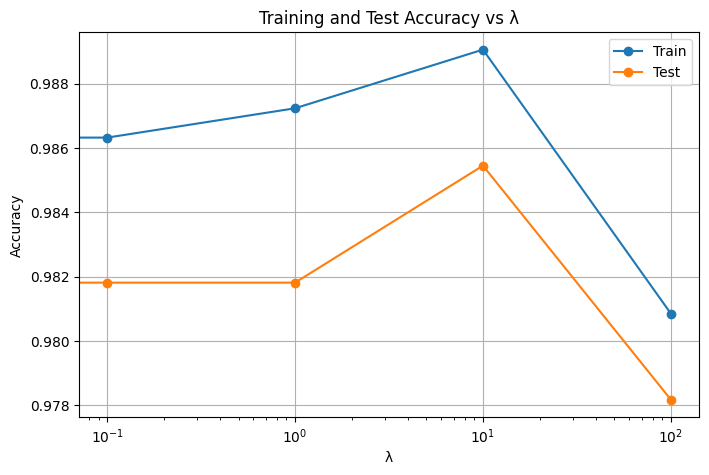

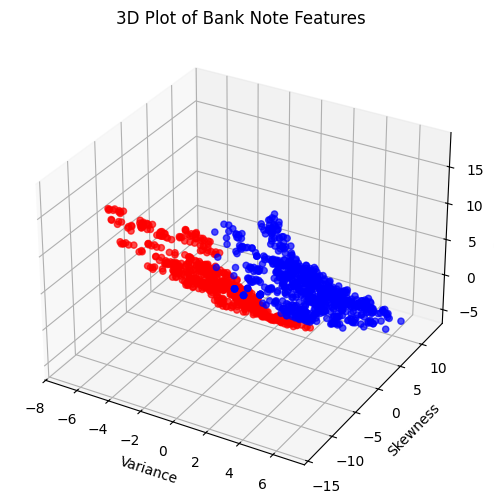


Effect of Outliers:
Without Regularization: Accuracy = 0.9164
With L2 Regularization (λ=1): Accuracy = 0.9164
Accuracy drop due to outliers (no reg): 0.916
Accuracy with L2 regularization: 0.916


In [8]:
# ------------------------------------------------------------
# 1.2 CLASSIFICATION: Bank Note Authentication
# ------------------------------------------------------------

df2 = pd.read_csv("/content/BankNote_Authentication.csv")

X = df2[['variance','skewness','curtosis','entropy']].values
y = df2['class'].values.reshape(-1,1)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add bias term
X_train_b = add_bias(X_train)
X_test_b = add_bias(X_test)

# === Logistic Regression from scratch ===
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_regression(X, y, lam=0.0, lr=0.01, epochs=10000):
    m, n = X.shape
    w = np.zeros((n,1))
    for i in range(epochs):
        y_pred = sigmoid(X @ w)
        grad = (1/m) * X.T @ (y_pred - y) + (lam/m)*w
        grad[0] -= (lam/m)*w[0]  # no reg for bias
        w -= lr * grad
    return w

# === Evaluate logistic regression ===
def evaluate_classification(X, y, w, label="Model"):
    y_pred_prob = sigmoid(X @ w)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    acc = accuracy_score(y, y_pred)
    print(f"{label}: Accuracy = {acc:.4f}")
    return acc

# Without and with L2 regularization
lambdas = [0, 0.1, 1, 10, 100]
train_acc, test_acc = [], []

for lam in lambdas:
    w = logistic_regression(X_train_b, y_train, lam=lam, lr=0.01, epochs=5000)
    tr = evaluate_classification(X_train_b, y_train, w, f"Train (λ={lam})")
    te = evaluate_classification(X_test_b, y_test, w, f"Test  (λ={lam})")
    train_acc.append(tr)
    test_acc.append(te)

# === Plot Accuracy vs λ ===
plt.figure(figsize=(8,5))
plt.plot(lambdas, train_acc, marker='o', label='Train')
plt.plot(lambdas, test_acc, marker='o', label='Test')
plt.xscale('log')
plt.xlabel("λ")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy vs λ")
plt.legend()
plt.grid(True)
plt.show()

# === 3D Visualization of 3 important features ===
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=y.flatten(), cmap='bwr', alpha=0.7)
ax.set_xlabel("Variance")
ax.set_ylabel("Skewness")
ax.set_zlabel("Curtosis")
ax.set_title("3D Plot of Bank Note Features")
plt.show()

# === Add Outliers ===
X_out = X_train.copy()
y_out = y_train.copy()
n_outliers = int(0.05 * len(X_out))
idx = np.random.choice(len(X_out), n_outliers, replace=False)
X_out[idx] += np.random.normal(10, 5, X_out[idx].shape)  # shift some points

# Fit classifier on outlier data
w_no_reg = logistic_regression(add_bias(X_out), y_out, lam=0.0, lr=0.01, epochs=5000)
w_l2_reg = logistic_regression(add_bias(X_out), y_out, lam=1.0, lr=0.01, epochs=5000)

print("\nEffect of Outliers:")
acc_no = evaluate_classification(X_test_b, y_test, w_no_reg, "Without Regularization")
acc_l2 = evaluate_classification(X_test_b, y_test, w_l2_reg, "With L2 Regularization (λ=1)")
print(f"Accuracy drop due to outliers (no reg): {acc_no:.3f}")
print(f"Accuracy with L2 regularization: {acc_l2:.3f}")
